In [0]:
% tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

# Print TF version, keep the version in mind when you look the documentation.
print('TensorFlow version: {}'.format(tf.__version__))

TensorFlow 2.x selected.
TensorFlow version: 2.1.0


In [0]:
import numpy as np
import os
import pandas as pd
import time, gc
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
from matplotlib import pyplot as plt
import pyarrow.parquet as pq

In [0]:
path = "/content/drive/My Drive/Data/bengaliai-cv19/" # TCC
# path="/content/drive/My Drive/data 2040 midterm private folder/Data/bengaliai-cv19/" # LSY

## Obtain Data from CSV and Parquet

Train, test label from CSV


In [0]:
train_df_ = pd.read_csv(path + 'train.csv')
test_df_ = pd.read_csv(path + 'test.csv')
class_map_df = pd.read_csv(path + 'class_map.csv')
sample_sub_df = pd.read_csv(path + 'sample_submission.csv')

In [0]:
train_df_.head()

image_id  grapheme_root  vowel_diacritic  consonant_diacritic grapheme
0  Train_0             15                9                    5   ক্ট্রো
1  Train_1            159                0                    0        হ
2  Train_2             22                3                    5     খ্রী
3  Train_3             53                2                    2     র্টি
4  Train_4             71                9                    5     থ্রো

In [0]:
print(f'Size of training data: {train_df_.shape}')
print(f'Size of test data: {test_df_.shape}')
print(f'Size of class map: {class_map_df.shape}')

Size of training data: (200840, 5)
Size of test data: (36, 3)
Size of class map: (186, 3)


In [0]:
print(f'Number of unique grapheme roots: {train_df_["grapheme_root"].nunique()}')
print(f'Number of unique vowel diacritic: {train_df_["vowel_diacritic"].nunique()}')
print(f'Number of unique consonant diacritic: {train_df_["consonant_diacritic"].nunique()}')

Number of unique grapheme roots: 168
Number of unique vowel diacritic: 11
Number of unique consonant diacritic: 7


The baseline of the model is $\frac{1}{168*11*7} = \frac{1}{12936}$

Get the top n or least n frequent labels of grapheme root, vowel diacritic or consonant diacritic.

In [0]:
def get_n(df, field, n, top=True):
    top_graphemes = df.groupby([field]).size().reset_index(name='counts')['counts'].sort_values(ascending=not top)[:n]
    top_grapheme_roots = top_graphemes.index
    top_grapheme_counts = top_graphemes.values
    top_graphemes = class_map_df[class_map_df['component_type'] == field].reset_index().iloc[top_grapheme_roots]
    top_graphemes.drop(['component_type', 'label'], axis=1, inplace=True)
    top_graphemes.loc[:, 'count'] = top_grapheme_counts
    return top_graphemes.drop(["index"], axis=1)

In [0]:
# Display top ten grapheme root
top_10_roots = get_n(train_df_, 'grapheme_root', 10)
top_10_roots

component  count
72          দ   5736
64          ত   5596
13          ক   5420
107         ব   5321
23          গ   5149
96          প   4926
113         ভ   4395
147         স   4392
133         শ   4374
115         ম   4015

In [0]:
# Display top five vowel diacritic
top_5_vowels = get_n(train_df_, 'vowel_diacritic', 5)
top_5_vowels

component  count
0         0  41508
1         া  36886
7         ে  28723
2         ি  25967
4         ু  18848

In [0]:
# Display top five consonant diacritic
top_5_consonants = get_n(train_df_, 'consonant_diacritic', 5)
top_5_consonants

component   count
0         0  125278
2        র্   23465
5        ্র   21397
4        ্য   21270
1         ঁ    7424

## EDA

Merge train data with test data based on iamge_id。

In [0]:
train_df_0 = pd.merge(pd.read_parquet(path + f'train_image_data_{0}.parquet'), train_df_, on='image_id')

Show a n by n grid containing the n samples of particular n grapheme roots, vowel diacritics or consonant diacritics

In [0]:
def show_top_feats_with_char(feat, size, row_num=10):
    """Plot most appeared features with characters"""
    # Find the correct df for input feature
    top_df = {"grapheme_root": top_10_roots, 
              "vowel_diacritic": top_5_vowels, 
              "consonant_diacritic": top_5_consonants}
    top_dic = top_df[feat]
    # Find the figures corresponding to the feature
    pic_dic = {}
    for i in top_dic.index:
        pic_dic[f"{feat}_{i}"] = train_df_0[train_df_0[feat] == i].iloc[:10, 1:32333]
    # plot words with the top feature
    fig, axs = plt.subplots(row_num, top_dic.shape[0], figsize=size)
    fig.suptitle(f'Plots of top {top_dic.shape[0]} {feat} on {row_num} characters')
    for col, ft_idx in enumerate(top_dic.index):
        for row in range(row_num):
            if row == 0:
                axs[row, col].set_title(ft_idx)    # Set title on 1st row
            temp = np.array(pic_dic[f"{feat}_{ft_idx}"].iloc[row, :])
            axs[row, col].matshow(temp.reshape([137, 236]))
            axs[row, col].axis('off')
    plt.show()

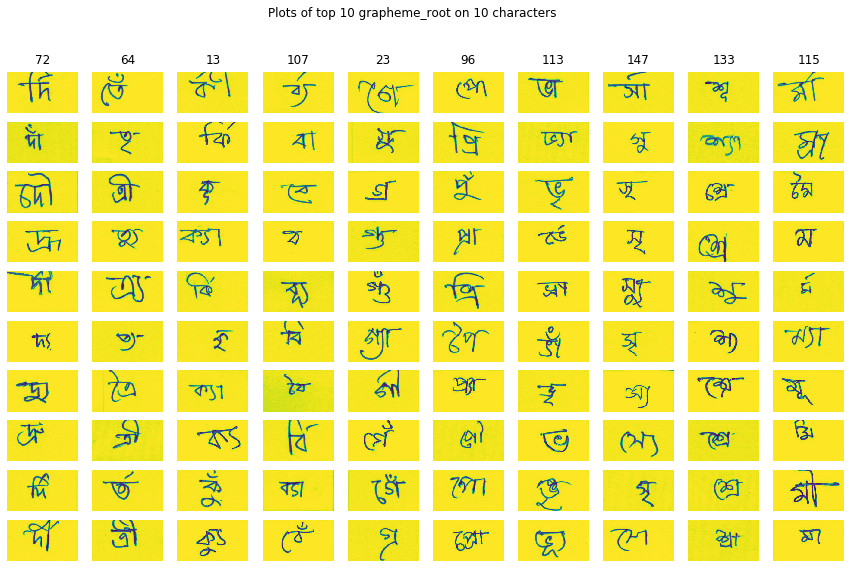

In [0]:
# 10 samples for the top 10 frequent grapheme roots.
show_top_feats_with_char(feat="grapheme_root", size=(15, 9), row_num=10)

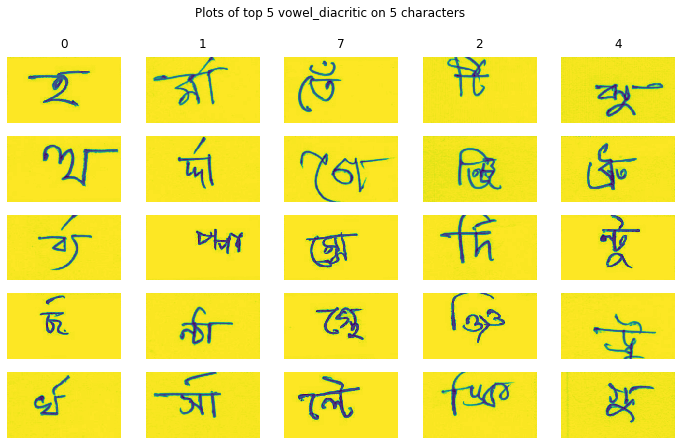

In [0]:
# 5 samples for the top 5 frequent vowel diacritics.
show_top_feats_with_char(feat="vowel_diacritic", size=(12, 7), row_num=5)

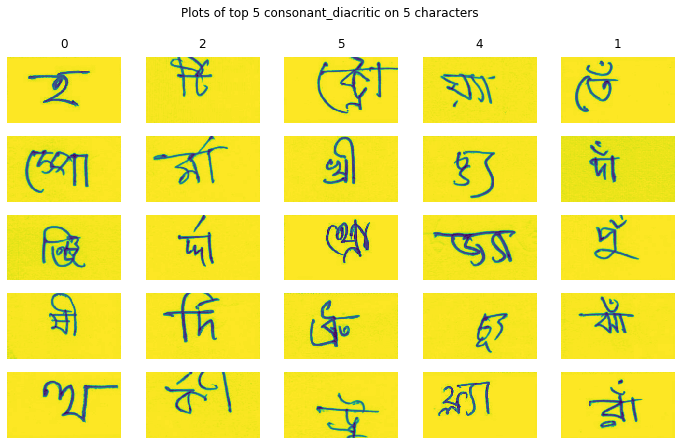

In [0]:
# 5 samples for the top 5 frequent consonant_diacritics.
show_top_feats_with_char(feat="consonant_diacritic", size=(12, 7), row_num=5)

Get n images with particular combinations of grapheme roots, vowel diacritics and consonant diacritics based on inputs.

In [0]:
# get n index based on desred gr, vd and cd
def get_index(n, dataset, gr_query, vd_query, cd_query):
  result = []
  cur_index = 0
  while len(result) < n and cur_index <= len(dataset):
    if dataset["grapheme_root"].iloc[cur_index] == gr_query and dataset["vowel_diacritic"].iloc[cur_index] == vd_query and dataset["consonant_diacritic"].iloc[cur_index] == cd_query:
      result.append(cur_index)
    cur_index += 1
  return result
desired_index_list = get_index(10, train_df_0, 72, 7, 5)
desired_index_list

[824, 1834, 2221, 3830, 4806, 6777, 7873, 8120, 9486, 9787]

15 9 5


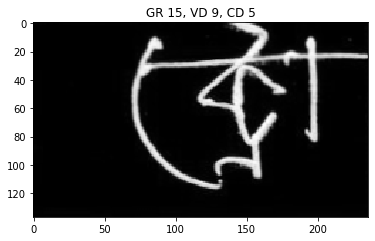

In [0]:
# a function with dataset, index as input and out put greyscale image
def display_image(dataset, index):
  plt.imshow(np.array(dataset.iloc[index][1:32333], dtype=float).reshape(137, 236), cmap='Greys')
  gr = dataset['grapheme_root'][index]
  vd = dataset['vowel_diacritic'][index]
  cd = dataset['consonant_diacritic'][index]
  print(gr,vd,cd)
  plt.title(f"GR {gr}, VD {vd}, CD {cd}")
  plt.show()
# Test trial
display_image(train_df_0, 0)

Plot the images with label 72, 7, 5 for  grapheme roots, vowel diacritics and consonant diacritics, respectively.

72 7 5


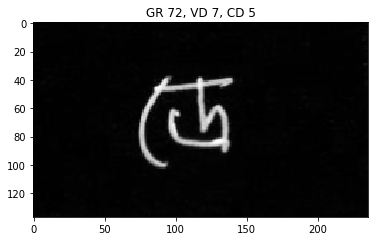

72 7 5


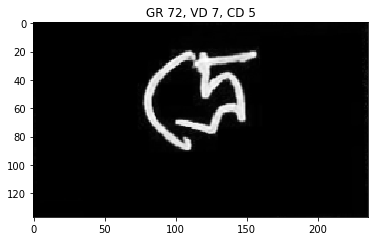

72 7 5


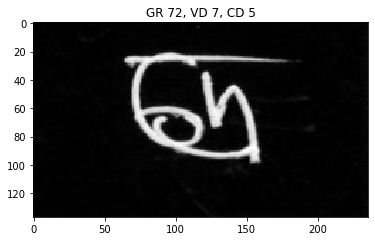

72 7 5


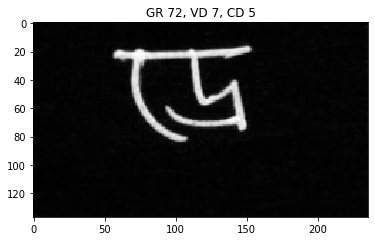

72 7 5


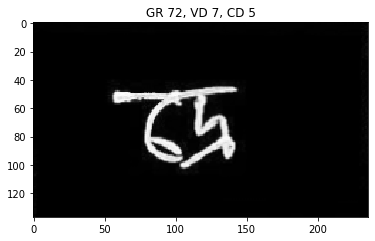

72 7 5


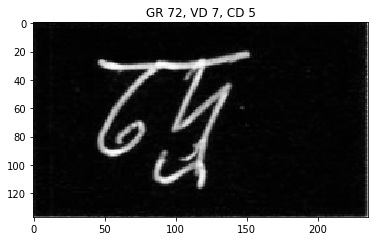

72 7 5


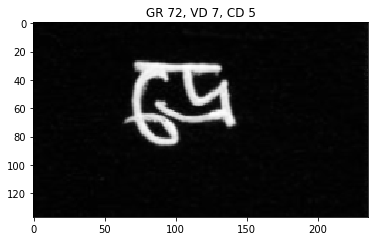

72 7 5


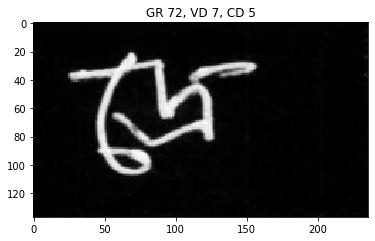

72 7 5


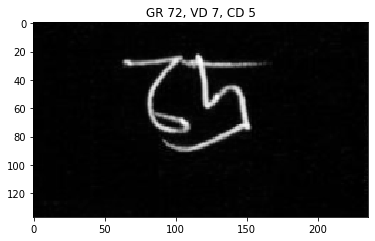

72 7 5


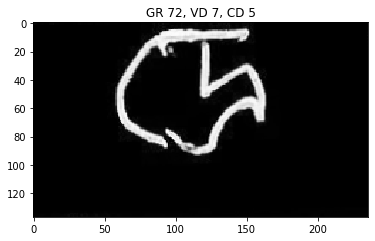

In [0]:
for index in desired_index_list:
  display_image(train_df_0, index)

To increase training speed and model accuracy, the images are first cropped to fufill the image with characters and then resized to a 64 by 64 pixel image.

In [0]:
# resize the dataframe
from tqdm.auto import tqdm
def resize(df, size=64, need_progress_bar=True):
    resized = {}
    resize_size=64
    if need_progress_bar:
        for i in tqdm(range(df.shape[0])):
            image=df.loc[df.index[i]].values.reshape(137,236)
            _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

            idx = 0 
            ls_xmin = []
            ls_ymin = []
            ls_xmax = []
            ls_ymax = []
            for cnt in contours:
                idx += 1
                x,y,w,h = cv2.boundingRect(cnt)
                ls_xmin.append(x)
                ls_ymin.append(y)
                ls_xmax.append(x + w)
                ls_ymax.append(y + h)
            xmin = min(ls_xmin)
            ymin = min(ls_ymin)
            xmax = max(ls_xmax)
            ymax = max(ls_ymax)

            roi = image[ymin:ymax,xmin:xmax]
            resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
            resized[df.index[i]] = resized_roi.reshape(-1)
    else:
        for i in range(df.shape[0]):
            image=df.loc[df.index[i]].values.reshape(137,236)
            _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

            idx = 0 
            ls_xmin = []
            ls_ymin = []
            ls_xmax = []
            ls_ymax = []
            for cnt in contours:
                idx += 1
                x,y,w,h = cv2.boundingRect(cnt)
                ls_xmin.append(x)
                ls_ymin.append(y)
                ls_xmax.append(x + w)
                ls_ymax.append(y + h)
            xmin = min(ls_xmin)
            ymin = min(ls_ymin)
            xmax = max(ls_xmax)
            ymax = max(ls_ymax)

            roi = image[ymin:ymax,xmin:xmax]
            resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
            resized[df.index[i]] = resized_roi.reshape(-1)
    resized = pd.DataFrame(resized).T
    return resized

In [0]:
resized_train_df_0 = resize(train_df_0.drop(['image_id', 'grapheme_root', 'vowel_diacritic', 'consonant_diacritic', 'grapheme'], axis=1))

In [0]:
resized_train_df_0.head

<bound method NDFrame.head of        0     1     2     3     4     5     ...  4090  4091  4092  4093  4094  4095
0       252   252   253   253   253   252  ...   255   255   255   255   255   254
1       255   255   255   255   255   255  ...   255   255   255   255   255   255
2       253   254   254   253   251   251  ...   139   106   105   121   160   217
3       249   252   250   251   249   249  ...   252   254   254   253   254   254
4       255   255   255   255   255   255  ...   255   255   255   255   255   255
...     ...   ...   ...   ...   ...   ...  ...   ...   ...   ...   ...   ...   ...
50205   254   254   254   254   254   254  ...   253   253   254   254   254   254
50206   254   254   254   254   255   253  ...   255   255   255   255   255   255
50207   243   240   238   244   246   242  ...   249   248   245   242   246   247
50208   243   238   240   236   230   235  ...   199   165   160   151   151   178
50209   233   155   207   223   117    97  ...   255   25

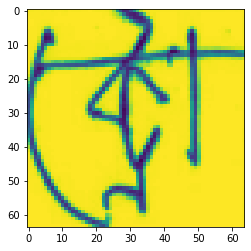

In [0]:
# sample 0
plt.imshow(np.array(resized_train_df_0.iloc[0]).reshape(64,64))

In [0]:
# Build DataGenerator
class MultiOutputDataGenerator(keras.preprocessing.image.ImageDataGenerator):

    def flow(self,
             x,
             y=None,
             batch_size=32,
             shuffle=True,
             sample_weight=None,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png',
             subset=None):

        targets = None
        target_lengths = {}
        ordered_outputs = []
        for output, target in y.items():
            if targets is None:
                targets = target
            else:
                targets = np.concatenate((targets, target), axis=1)
            target_lengths[output] = target.shape[1]
            ordered_outputs.append(output)


        for flowx, flowy in super().flow(x, targets, batch_size=batch_size,
                                         shuffle=shuffle):
            target_dict = {}
            i = 0
            for output in ordered_outputs:
                target_length = target_lengths[output]
                target_dict[output] = flowy[:, i: i + target_length]
                i += target_length

            yield flowx, target_dict

## Model Training

In [0]:
# Build an in itial model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
IMG_SIZE = 64
inputs = keras.Input(shape = (IMG_SIZE, IMG_SIZE, 1))

model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1))(inputs)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = keras.layers.BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=32, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = keras.layers.BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=64, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = keras.layers.BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = keras.layers.BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=128, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = keras.layers.BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = keras.layers.BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=256, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = keras.layers.BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Flatten()(model)
model = Dense(1024, activation = "relu")(model)
model = Dropout(rate=0.3)(model)
dense = Dense(512, activation = "relu")(model)

head_root = Dense(168, activation = 'softmax')(dense)
head_vowel = Dense(11, activation = 'softmax')(dense)
head_consonant = Dense(7, activation = 'softmax')(dense)

model = keras.models.Model(inputs=inputs, outputs=[head_root, head_vowel, head_consonant])

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
root_dense = model.layers[-3].name
vowel_dense = model.layers[-2].name
consonant_dense = model.layers[-1].name
print(root_dense, vowel_dense, consonant_dense)

dense_2 dense_3 dense_4


In [0]:
IMG_SIZE=64
N_CHANNELS=1
batch_size = 256
epochs = 30
HEIGHT = 137
WIDTH = 236

Build a Tensorboard for visualizing the training/validation accuracy history and training/validation loss.

In [0]:
# Tensor Board
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
run_logdir
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

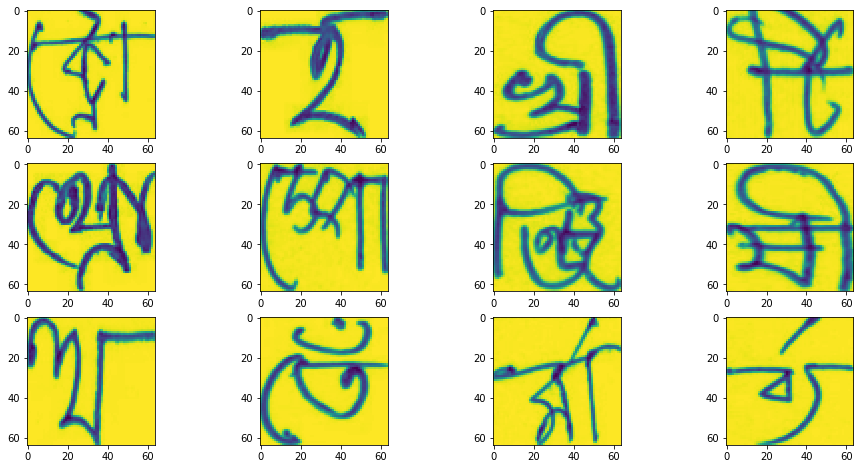


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
  {'dense_2': '...', 'dense_3': '...', 'dense_4': '...'}
    to  
  ['...', '...', '...']
Train for 180 steps, validate on 4017 samples
Epoch 1/30
180/180 [==============================] - 35s 197ms/step - loss: 7.8113 - dense_2_loss: 4.7652 - dense_3_loss: 1.8401 - dense_4_loss: 1.2060 - dense_2_accuracy: 0.0292 - dense_3_accuracy: 0.3539 - dense_4_accuracy: 0.6206 - val_loss: 6.9713 - val_dense_2_loss: 4.5774 - val_dense_3_loss: 1.3560 - val_dense_4_loss: 1.0392 - val_dense_2_accuracy: 0.0356 - val_dense_3_accuracy: 0.5046 - val_dense_4_accuracy: 0.6164
Epoch 2/30
180/180 [==============================] - 26s 143ms/step - loss: 6.7026 - dense_2_loss: 4.4968 - dense_3_loss: 1.1929 - dense_4_loss: 1.0129 - dense_2_accuracy: 0.0419 - dense_3_accuracy: 0.5837 - dense_4_accuracy: 0.6521 - val_loss: 6.0708 - val_dense_2_loss: 4.3286 - val_dense

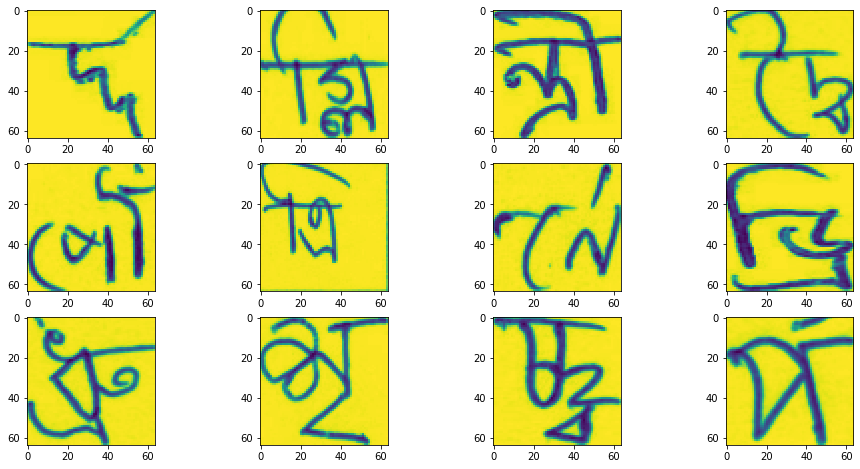


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
  {'dense_2': '...', 'dense_3': '...', 'dense_4': '...'}
    to  
  ['...', '...', '...']
Train for 180 steps, validate on 4017 samples
Epoch 1/30
180/180 [==============================] - 25s 141ms/step - loss: 1.0158 - dense_2_loss: 0.5933 - dense_3_loss: 0.2496 - dense_4_loss: 0.1730 - dense_2_accuracy: 0.8373 - dense_3_accuracy: 0.9289 - dense_4_accuracy: 0.9482 - val_loss: 0.6671 - val_dense_2_loss: 0.3376 - val_dense_3_loss: 0.2341 - val_dense_4_loss: 0.0955 - val_dense_2_accuracy: 0.9081 - val_dense_3_accuracy: 0.9238 - val_dense_4_accuracy: 0.9726
Epoch 2/30
180/180 [==============================] - 25s 141ms/step - loss: 0.9062 - dense_2_loss: 0.5223 - dense_3_loss: 0.2258 - dense_4_loss: 0.1581 - dense_2_accuracy: 0.8543 - dense_3_accuracy: 0.9367 - dense_4_accuracy: 0.9525 - val_loss: 0.4940 - val_dense_2_loss: 0.3116 - val_dense

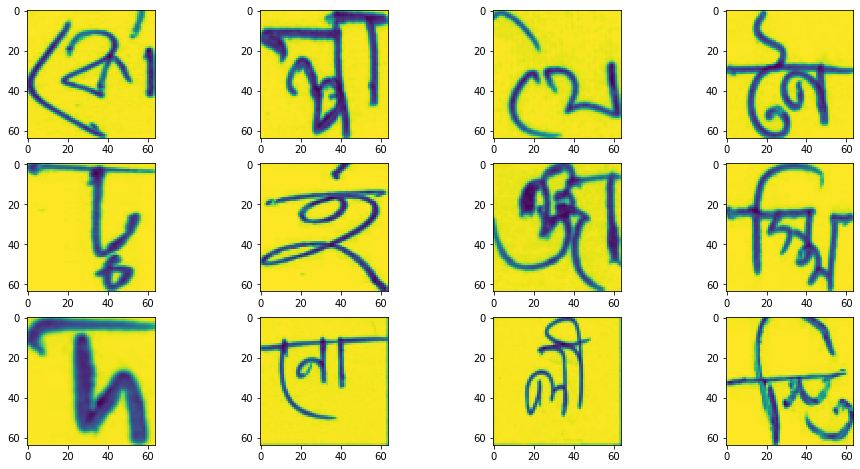


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
  {'dense_2': '...', 'dense_3': '...', 'dense_4': '...'}
    to  
  ['...', '...', '...']
Train for 180 steps, validate on 4017 samples
Epoch 1/30
180/180 [==============================] - 26s 143ms/step - loss: 0.7611 - dense_2_loss: 0.4394 - dense_3_loss: 0.1878 - dense_4_loss: 0.1338 - dense_2_accuracy: 0.8824 - dense_3_accuracy: 0.9479 - dense_4_accuracy: 0.9603 - val_loss: 0.4165 - val_dense_2_loss: 0.2584 - val_dense_3_loss: 0.0795 - val_dense_4_loss: 0.0799 - val_dense_2_accuracy: 0.9293 - val_dense_3_accuracy: 0.9816 - val_dense_4_accuracy: 0.9786
Epoch 2/30
180/180 [==============================] - 26s 142ms/step - loss: 0.6724 - dense_2_loss: 0.3825 - dense_3_loss: 0.1686 - dense_4_loss: 0.1213 - dense_2_accuracy: 0.8954 - dense_3_accuracy: 0.9527 - dense_4_accuracy: 0.9635 - val_loss: 0.3823 - val_dense_2_loss: 0.2349 - val_dense

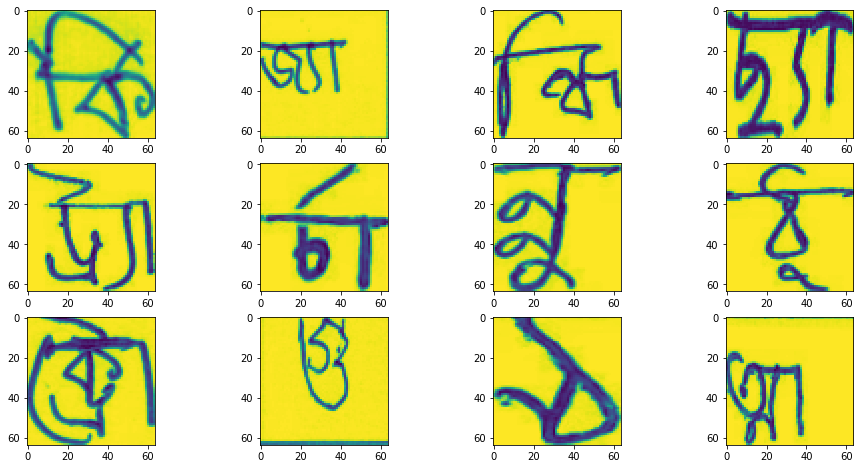


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
  {'dense_2': '...', 'dense_3': '...', 'dense_4': '...'}
    to  
  ['...', '...', '...']
Train for 180 steps, validate on 4017 samples
Epoch 1/30
180/180 [==============================] - 25s 141ms/step - loss: 0.6744 - dense_2_loss: 0.3859 - dense_3_loss: 0.1691 - dense_4_loss: 0.1194 - dense_2_accuracy: 0.8979 - dense_3_accuracy: 0.9520 - dense_4_accuracy: 0.9648 - val_loss: 0.3515 - val_dense_2_loss: 0.2131 - val_dense_3_loss: 0.0767 - val_dense_4_loss: 0.0604 - val_dense_2_accuracy: 0.9427 - val_dense_3_accuracy: 0.9826 - val_dense_4_accuracy: 0.9838
Epoch 2/30
180/180 [==============================] - 25s 141ms/step - loss: 0.5729 - dense_2_loss: 0.3223 - dense_3_loss: 0.1464 - dense_4_loss: 0.1041 - dense_2_accuracy: 0.9109 - dense_3_accuracy: 0.9586 - dense_4_accuracy: 0.9693 - val_loss: 0.3574 - val_dense_2_loss: 0.2118 - val_dense

In [0]:
histories = []
for i in range(4):
    train_df = pd.merge(pd.read_parquet(path+f'train_image_data_{i}.parquet'), train_df_, on='image_id').drop(['image_id', 'grapheme'], axis=1)
    
    # Visualize few samples of current training dataset
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 8))
    count=0
    for row in ax:
        for col in row:
            col.imshow(resize(train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1).iloc[[count]], need_progress_bar=False).values.reshape(-1).reshape(IMG_SIZE, IMG_SIZE).astype(np.float64))
            count += 1
    plt.show()
    
    X_train = train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1)
    X_train = resize(X_train)/255
    
    # CNN takes images in shape `(batch_size, h, w, channels)`, so reshape the images
    X_train = X_train.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
    Y_train_root = pd.get_dummies(train_df['grapheme_root']).values
    Y_train_vowel = pd.get_dummies(train_df['vowel_diacritic']).values
    Y_train_consonant = pd.get_dummies(train_df['consonant_diacritic']).values

    print(f'Training images: {X_train.shape}')
    print(f'Training labels root: {Y_train_root.shape}')
    print(f'Training labels vowel: {Y_train_vowel.shape}')
    print(f'Training labels consonants: {Y_train_consonant.shape}')

    # Divide the data into training and validation set
    x_train, x_test, y_train_root, y_test_root, y_train_vowel, y_test_vowel, y_train_consonant, y_test_consonant = train_test_split(X_train, Y_train_root, Y_train_vowel, Y_train_consonant, test_size=0.08, random_state=666)
    del train_df
    del X_train
    del Y_train_root, Y_train_vowel, Y_train_consonant

    # Data augmentation for creating more training data
    datagen = MultiOutputDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


    # This will just calculate parameters required to augment the given data. This won't perform any augmentations
    datagen.fit(x_train)

    # Fit the model
    history = model.fit_generator(datagen.flow(x_train, {root_dense: y_train_root, vowel_dense: y_train_vowel, consonant_dense: y_train_consonant}, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test, [y_test_root, y_test_vowel, y_test_consonant]), 
                              steps_per_epoch=x_train.shape[0] // batch_size, 
                              callbacks=[tensorboard_cb])

    histories.append(history)
    
    # Delete to reduce memory usage
    del x_train
    del x_test
    del y_train_root
    del y_test_root
    del y_train_vowel
    del y_test_vowel
    del y_train_consonant
    del y_test_consonant
    gc.collect()

In [0]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 162), started 1:18:24 ago. (Use '!kill 162' to kill it.)

In [0]:
%tensorboard --logdir=./my_logs --port=6006

Output hidden; open in https://colab.research.google.com to view.

In [0]:
del x_train
del x_test
del y_train_root
del y_test_root
del y_train_vowel
del y_test_vowel
del y_train_consonant
del y_test_consonant

In [0]:
# Save model
model_name = 'initial_model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/saved_models/initial_model.h5 


In [0]:
# Test Data
dict_pred = {
    'grapheme_root': [],
    'vowel_diacritic': [],
    'consonant_diacritic': []
}
components = ['consonant_diacritic', 'grapheme_root', 'vowel_diacritic']
target=[] # model predictions placeholder
row_id=[] # row_id place holder
for i in range(4):
    df_test_img = pd.read_parquet(path + f'test_image_data_{i}.parquet') 
    df_test_img.set_index('image_id', inplace=True)

    X_test = resize(df_test_img, need_progress_bar=False)/255
    X_test = X_test.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
    preds = model.predict(X_test)

    for i, p in enumerate(dict_pred):
        dict_pred[p] = np.argmax(preds[i], axis=1)

    for k,id in enumerate(df_test_img.index.values):  
        for i,comp in enumerate(components):
            id_sample=id+'_'+comp
            row_id.append(id_sample)
            target.append(dict_pred[comp][k])
    del df_test_img
    del X_test
    gc.collect()

df_sample = pd.DataFrame(
    {
        'row_id': row_id,
        'target':target
    },
    columns = ['row_id','target'] 
)
df_sample.to_csv('submission.csv',index=False)
df_sample.head()

row_id  target
0  Test_0_consonant_diacritic       0
1        Test_0_grapheme_root       3
2      Test_0_vowel_diacritic       0
3  Test_1_consonant_diacritic       0
4        Test_1_grapheme_root      93